In [1]:
# Importing the libraries

import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import numpy as np

import seaborn as sns

Data Preparation

Download the dataset from Kaggle.
Load the dataset and inspect it for missing values, outliers, and normalization requirements.
Split the dataset into training and testing sets.

The dataset was downloaded from Kaggle at https://www.kaggle.com/code/koheimuramatsu/iot-temperature-forecasting

In [2]:
# Load the dataset
df = pd.read_csv('IOT-temp.csv')

# Examine the dataset by printing the column names and first 5 rows
print(df.head())

# Check for NA values in the dataset
missing_values = df.isnull().sum()

print('Missing Valies', missing_values)

                                    id  room_id/id        noted_date  temp  \
0  __export__.temp_log_196134_bd201015  Room Admin  08-12-2018 09:30    29   
1  __export__.temp_log_196131_7bca51bc  Room Admin  08-12-2018 09:30    29   
2  __export__.temp_log_196127_522915e3  Room Admin  08-12-2018 09:29    41   
3  __export__.temp_log_196128_be0919cf  Room Admin  08-12-2018 09:29    41   
4  __export__.temp_log_196126_d30b72fb  Room Admin  08-12-2018 09:29    31   

  out/in  
0     In  
1     In  
2    Out  
3    Out  
4     In  
Missing Valies id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64


In [3]:
# Remove any rows with NA values
df.dropna()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In
...,...,...,...,...,...
97601,__export__.temp_log_91076_7fbd08ca,Room Admin,28-07-2018 07:07,31,In
97602,__export__.temp_log_147733_62c03f31,Room Admin,28-07-2018 07:07,31,In
97603,__export__.temp_log_100386_84093a68,Room Admin,28-07-2018 07:06,31,In
97604,__export__.temp_log_123297_4d8e690b,Room Admin,28-07-2018 07:06,31,In


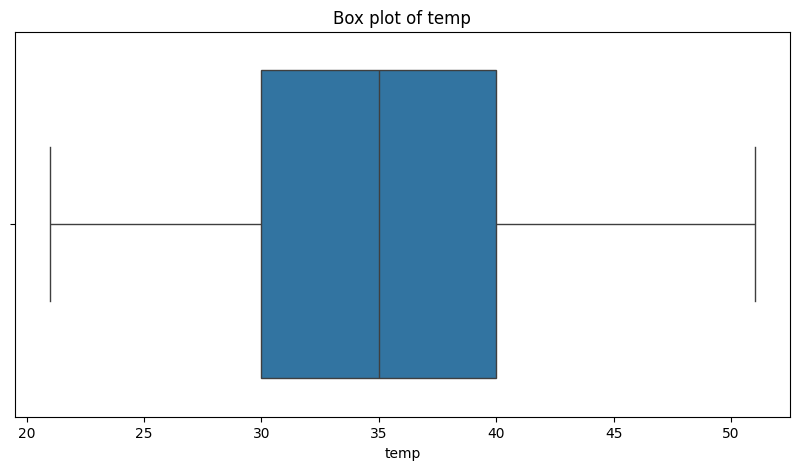

In [4]:

# Select numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot box plots for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()


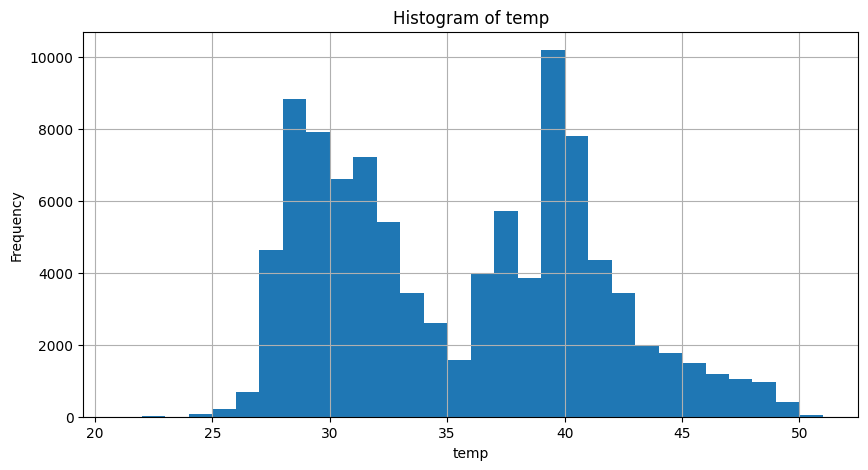

In [5]:
# Plot histograms for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 5))
    df[column].hist(bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [6]:
# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


In [7]:
# Split the dataset into Test and Train

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

Training set: (78084, 5)
Testing set: (19522, 5)


Model Selection and Training

Explore Nixtla's AutoML capabilities to select and train a forecasting model suitable for this dataset.
Document the model selection process and the reasoning behind the chosen model.

In [8]:
# Check if columns have already been renamed
if 'ds' in df.columns and 'y' in df.columns:
    print("Columns already renamed")
else:
    # Convert 'noted_date' to datetime format
    df['noted_date'] = pd.to_datetime(df['noted_date'], format='%d-%m-%Y %H:%M')

    # Rename columns to match the expected format for MLForecast
    df = df.rename(columns={'noted_date': 'ds', 'temp': 'y'})
    df['unique_id'] = 'temperature_series'  # Assuming a single time series



# Reorder columns to the expected order
df = df[['unique_id', 'ds', 'y']]

# Basic information and statistics
print(df.info())
print(df.describe())

# Train-test split based on time series
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

print(f"Training set: {train.shape}")
print(f"Testing set: {test.shape}")

models = {
    'RandomForrest': RandomForestRegressor(n_estimators=100),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100)
}

results = {}

for model_name, model in models.items():
    print(f"Fitting {model_name}...")
    forecaster = MLForecast(
        models=[
            (model)
        ],
        freq='D',  # Daily frequency
        lags=[1, 2, 3],  # Include lags 1, 2, and 3
        date_features=['year', 'month', 'day'],  # Include year, month, and day as date features
        num_threads=4  # Use 4 threads for parallel processing
    )

    forecaster.fit(train)
    predictions = forecaster.predict(len(test))

    results[model_name] = predictions


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  97606 non-null  object        
 1   ds         97606 non-null  datetime64[ns]
 2   y          97606 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.2+ MB
None
                                  ds             y
count                          97606  97606.000000
mean   2018-10-07 05:10:38.821178880      0.468464
min              2018-07-28 07:06:00      0.000000
25%              2018-09-11 07:48:00      0.300000
50%              2018-10-17 05:10:00      0.466667
75%              2018-10-18 13:46:00      0.633333
max              2018-12-08 09:30:00      1.000000
std                              NaN      0.189994
Training set: (78084, 3)
Testing set: (19522, 3)
Fitting RandomForrest...
Fitting GradientBoosting...


Plotting the output comparing Test vs RandomForrestRegression and GradientBoostingRegression

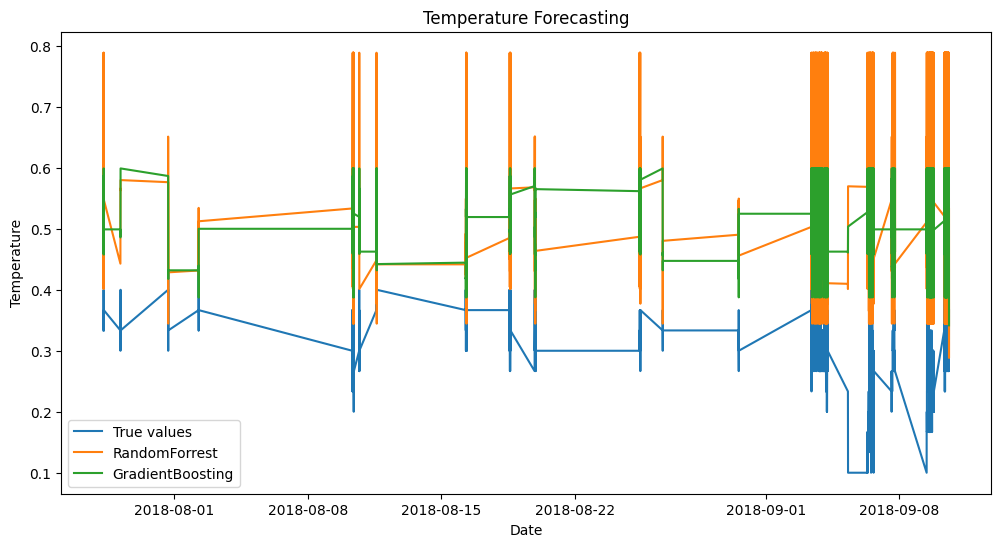

In [9]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='True values')

# Extract and plot predictions for each model
for model_name, predictions_df in results.items():
    # Extract the prediction column (third column in the DataFrame)
    predictions_series = predictions_df.iloc[:, 2]
    plt.plot(test['ds'], predictions_series, label=model_name)

plt.title('Temperature Forecasting')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Evaluation

Evaluate your model using appropriate time series metrics (e.g., MAE, MSE, MASE).
Perform rolling-origin cross-validation to ensure the model's robustness.
Summarize the evaluation results and discuss potential improvements.

In [12]:
# Evaluate the models

print("Model Evaluation:")
for model_name, predictions_df in results.items():
    predictions_series = predictions_df.iloc[:, 2]  # Extract the prediction column
    mae = mean_absolute_error(test['y'], predictions_series)
    mse = mean_squared_error(test['y'], predictions_series)
    print(f"{model_name}: MAE = {mae:.3f}, MSE = {mse:.3f}")
print("Closer to 0 is better")

Model Evaluation:
RandomForrest: MAE = 0.215, MSE = 0.053
GradientBoosting: MAE = 0.205, MSE = 0.047
Closer to 0 is better


Rolling-origin cross-validation to ensure the model's robustness.

In [13]:
# Function to perform rolling-origin cross-validation
def rolling_origin_cv(df, model, window_size, step_size):
    results = []
    n = len(df)
    
    for start in range(0, n - window_size, step_size):
        train = df.iloc[start:start + window_size]
        test = df.iloc[start + window_size:start + window_size + step_size]
        
        forecaster = MLForecast(
            models=[model],
            freq='D',
            lags=[1, 2, 3],
            date_features=['year', 'month', 'day'],
            num_threads=4
        )
        
        forecaster.fit(train, id_col='unique_id', time_col='ds', target_col='y')
        
        predictions = forecaster.predict(len(test))
        
        if predictions.ndim == 2:
            predictions = predictions.flatten()
        
        mae = mean_absolute_error(test['y'], predictions)
        mse = mean_squared_error(test['y'], predictions)
        
        results.append({'mae': mae, 'mse': mse})
    
    return pd.DataFrame(results)


unique_df = df[['unique_id', 'ds', 'y']]

# Parameters for rolling-origin cross-validation
window_size = int(len(unique_df) * 0.6)  # Initial training window size (60% of data)
step_size = int(len(unique_df) * 0.2)    # Step size for moving window (20% of data)

# Define the model to evaluate
model = RandomForestRegressor(n_estimators=100)

# Perform rolling-origin cross-validation
cv_results = rolling_origin_cv(unique_df, model, window_size, step_size)

# Print results
print("Rolling-Origin Cross-Validation Results:")
print(cv_results)
print("\nAverage MAE:", cv_results['mae'].mean())
print("Average MSE:", cv_results['mse'].mean())


In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from sklearn.metrics import mean_squared_error

# Function to evaluate performance
def evaluate_threads(thread_counts, train, test):
    results = {}
    for threads in thread_counts:
        start_time = time.time()
        
        # Initialize MLForecast with the specified number of threads
        forecaster = MLForecast(
            models=[
                RandomForestRegressor(n_estimators=100, n_jobs=threads)
            ],
            freq='D',  # Adjust frequency as per your dataset's granularity
            lags=[1, 2, 3],  # Example lags; modify as needed
            date_features=['year', 'month', 'day'],
            num_threads=threads  # Adjust based on the current setting
        )
        
        # Fit the forecaster on the training data
        forecaster.fit(train, id_col='unique_id', time_col='ds', target_col='y')

        # Predict on the test data
        predictions = forecaster.predict(len(test))
        if predictions.ndim == 2:
            predictions = predictions.flatten()

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test['y'], predictions))
        elapsed_time = time.time() - start_time

        results[threads] = {'rmse': rmse, 'time': elapsed_time}
        print(f"Threads: {threads}, RMSE: {rmse}, Time: {elapsed_time}s")
    
    return results

# Define the range of thread counts to test
thread_counts = range(1, logical_cores + 1)

# Assuming train and test dataframes are already defined
results = evaluate_threads(thread_counts, train, test)

# Find the optimal thread count based on RMSE and execution time
optimal_threads = min(results, key=lambda k: results[k]['rmse'])
print(f"Optimal thread count based on RMSE: {optimal_threads}")
